In [67]:
import numpy as np
import cv2
import cv2.aruco as aruco
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import os

In [6]:
# Side view
side_view_camera_calibration_dir = "/home/joseph/Documents/project/videos/calibration_images/LG_calibration/20241110_152519_jpg/"
calibration_file = side_view_camera_calibration_dir + "calibration_data.out.npz"
side_view_folder = "/home/joseph/Documents/project/videos/calibration_images/rotation_calibration/side_view_LG/"
side_view_image = side_view_folder + "alignment/" + "20241112_122114.jpg"

In [12]:
video_file = side_view_folder + "20241112_122400.mp4"


In [11]:
reference_id = 8
marker_size = 0.02 #m

In [7]:
npzfile = np.load(calibration_file)

print(sorted(npzfile.files))
print(npzfile['mtx'])
print(npzfile['dist'])
print(npzfile['ret'])

matrix_coefficients = npzfile['mtx']
distortion_coefficients = npzfile['dist']

['dist', 'mtx', 'ret']
[[2.08523524e+03 0.00000000e+00 9.78645368e+02]
 [0.00000000e+00 2.09604590e+03 5.17528098e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 3.23649502e-01 -2.50464810e+00 -1.41125650e-02  4.40982137e-03
   7.27829931e+00]]
1.1953634493950598


In [8]:
img_path = side_view_image
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
arucoParameters =  cv2.aruco.DetectorParameters()
arucoDetector = cv2.aruco.ArucoDetector(arucoDict, arucoParameters)

# lists of ids and the corners beloning to each id
corners, ids, rejected_img_points = arucoDetector.detectMarkers(gray)
annotated_frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
aruco.drawDetectedMarkers(annotated_frame, corners)

array([[[ 24,  24,  24],
        [ 22,  22,  22],
        [ 23,  23,  23],
        ...,
        [186, 186, 186],
        [187, 187, 187],
        [187, 187, 187]],

       [[ 23,  23,  23],
        [ 22,  22,  22],
        [ 23,  23,  23],
        ...,
        [184, 184, 184],
        [185, 185, 185],
        [185, 185, 185]],

       [[ 24,  24,  24],
        [ 23,  23,  23],
        [ 23,  23,  23],
        ...,
        [184, 184, 184],
        [185, 185, 185],
        [185, 185, 185]],

       ...,

       [[180, 180, 180],
        [181, 181, 181],
        [182, 182, 182],
        ...,
        [151, 151, 151],
        [158, 158, 158],
        [158, 158, 158]],

       [[182, 182, 182],
        [182, 182, 182],
        [183, 183, 183],
        ...,
        [153, 153, 153],
        [159, 159, 159],
        [160, 160, 160]],

       [[182, 182, 182],
        [182, 182, 182],
        [181, 181, 181],
        ...,
        [154, 154, 154],
        [154, 154, 154],
        [154, 154, 154]]

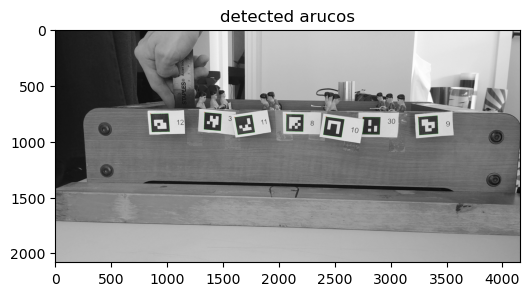

In [9]:
annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
aruco_img = Image.fromarray(annotated_frame_rgb)

plt.figure(figsize=(6, 4))
plt.title("detected arucos")
plt.imshow(aruco_img)

In [20]:
def print_rotation(r):
    print(r * 180 / np.pi)

def get_pose_of_id(aruco_id, corner_dict, marker_size, mtx, dist):
    objectPoints = np.array([
    [-marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, -marker_size / 2, 0],
    [-marker_size / 2, -marker_size / 2, 0]])
    
    retval_1, rvec_1, tvec_1 = cv2.solvePnP(objectPoints, corner_dict[aruco_id], mtx, dist, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    return rvec_1

def get_rotation_between_ids(id1, id2, corner_dict, marker_size, mtx, dist):
    objectPoints = np.array([
    [-marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, marker_size / 2, 0],
    [ marker_size / 2, -marker_size / 2, 0],
    [-marker_size / 2, -marker_size / 2, 0]])
    
    retval_1, rvec_1, tvec_1 = cv.solvePnP(objectPoints, corner_dict[id1], mtx, dist, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    print("r1=")
    print_rotation(rvec_1)
    retval_2, rvec_2, tvec_2 = cv.solvePnP(objectPoints, corner_dict[id2], mtx, dist, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    print("r2=")
    print_rotation(rvec_2)
    r_1_2, t_1_2 = relativePosition(tvec_1, tvec_2, rvec_1, rvec_2)
    return r_1_2, t_1_2


In [21]:
def plot_rotations(aruco_id, rotations, time):
    # PLot
    plt.plot(time, rotations[:,0], label='rot-0')
    plt.plot(time, rotations[:,1], label='rot-1')
    plt.plot(time, rotations[:,2], label='rot-2')
    
    # Add Title
    plt.title(f"Rotations for aruco {aruco_id}") 
    
    # Add Axes Labels
    
    
    plt.xlabel("time") 
    plt.ylabel("rotation") 
    plt.legend()
    # Display
    
    plt.show()
    

In [22]:
def plot_theta(aruco_id, theta, time):
    # PLot
    plt.plot(time, theta * 180 / np.pi, label='theta')
    # Add Title
    plt.title(f"Aruco {aruco_id} theta") 
    
    # Add Axes Labels
    plt.xlabel("time") 
    plt.ylabel("theta") 
    plt.legend()
    # Display
    
    plt.show()

In [34]:
capture = cv2.VideoCapture(video_file)

length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
fps = capture.get(cv2.CAP_PROP_FPS)
duration = length / fps #seconds

aruco_id_list = [8, 9, 10, 11, 12]
id_index_dict = {9:0, 10:1, 11:2, 12:3, 8:4}
rotations = np.zeros((length, len(aruco_id_list), 3))

print(length)
print(duration)

img_idx = 0
while(capture.isOpened()):
    (grabbed, img) = capture.read()
    
    if grabbed == True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
        arucoParameters =  cv2.aruco.DetectorParameters()
        arucoDetector = cv2.aruco.ArucoDetector(arucoDict, arucoParameters)
        
        # lists of ids and the corners beloning to each id
        corners, ids, rejected_img_points = arucoDetector.detectMarkers(gray)

        id_list = ids.flatten()
        corner_dict = {id_list[i]: corners[i] for i in range(len(id_list))}
        
        # annotated_frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        # aruco.drawDetectedMarkers(annotated_frame, corners)

        for aruco_id in aruco_id_list:
            if aruco_id in id_list:
                rvec = get_pose_of_id(aruco_id, corner_dict, marker_size, matrix_coefficients, distortion_coefficients)
                array_idx = id_index_dict[aruco_id]
                rotations[img_idx, array_idx] = rvec.flatten()
        img_idx+=1
    else:
        break
    
capture.release()

2302
76.68328888888888


2302
[0. 0. 0.]
(2302, 3)


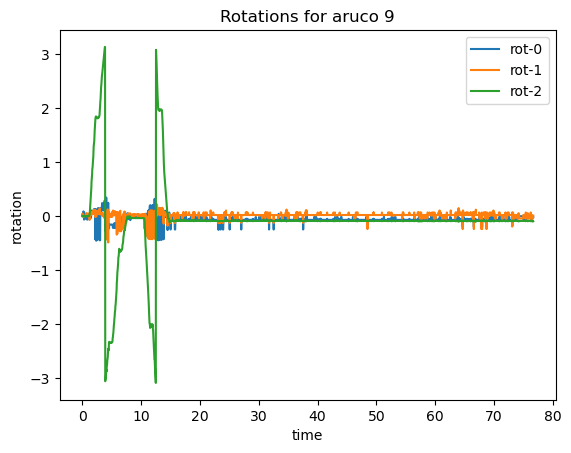

In [30]:
numpy_rot_list = Rotation.from_rotvec(aruco_9_rotations)
print(len(numpy_rot_list))
R0 = numpy_rot_list[0]
R0_inv = numpy_rot_list[0].inv()
print((R0 * R0_inv).as_rotvec())

zeroed_rotations = (R0_inv * numpy_rot_list).as_rotvec()
print(zeroed_rotations.shape)

plt.close("all")
plot_rotations(9, zeroed_rotations, time)

2302
[0. 0. 0.]


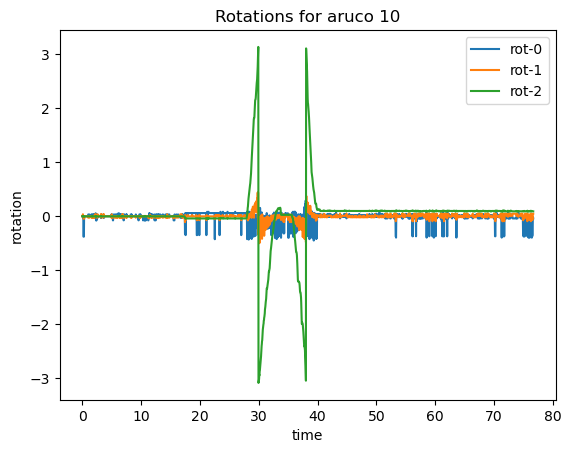

In [31]:
aruco_10_rotations = rotations[:,id_index_dict[10],:]
numpy_rot_list = Rotation.from_rotvec(aruco_10_rotations)
print(len(numpy_rot_list))
R0 = numpy_rot_list[0]
R0_inv = numpy_rot_list[0].inv()
print((R0 * R0_inv).as_rotvec())

zeroed_rotations = (R0_inv * numpy_rot_list).as_rotvec()
plt.close("all")
plot_rotations(10, zeroed_rotations, time)

[1.08420217e-19 0.00000000e+00 0.00000000e+00]


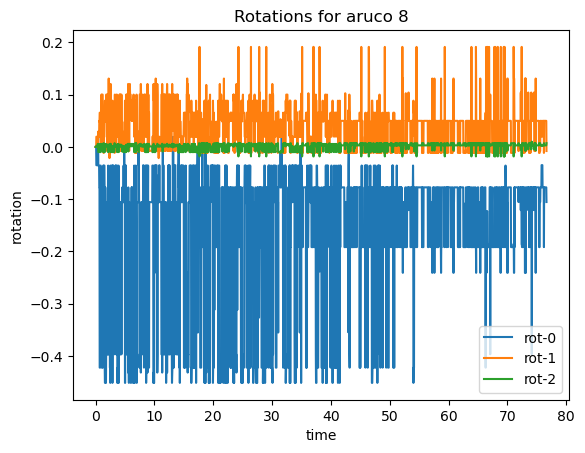

In [44]:
aruco_8_rotation_vecs = rotations[:,id_index_dict[8],:]
aruco_8_rotations = Rotation.from_rotvec(aruco_8_rotation_vecs)
R0 = aruco_8_rotations[0]
R0_inv = aruco_8_rotations[0].inv()
print((R0 * R0_inv).as_rotvec())

zeroed_rotations = (R0_inv * numpy_rot_list).as_rotvec()
plt.close("all")
plot_rotations(8, zeroed_rotations, time)

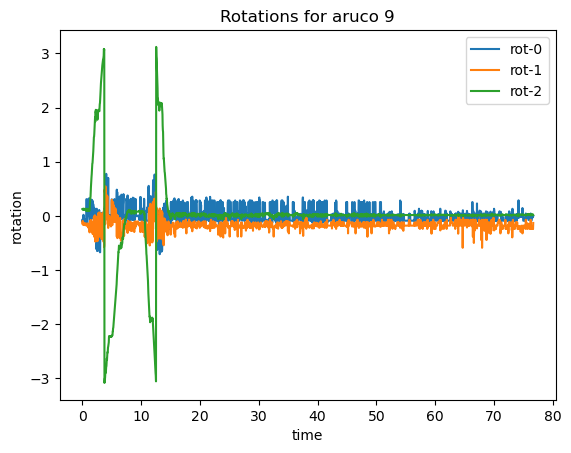

In [46]:
aruco_9_rot_list = Rotation.from_rotvec(aruco_9_rotations)
aruco_8_rot_inv_list = aruco_8_rotations.inv()
zeroed_rotations = (aruco_8_rot_inv_list * aruco_9_rot_list)

zeroed_rotation_vecs = zeroed_rotations.as_rotvec()
plt.close("all")
plot_rotations(9, zeroed_rotation_vecs, time)

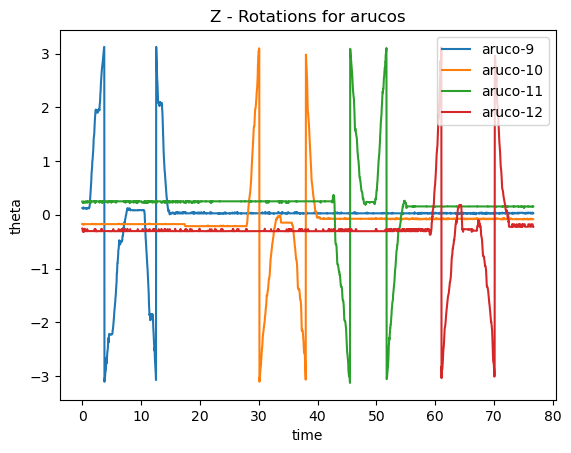

In [55]:
aruco_9_rot_list = Rotation.from_rotvec(aruco_9_rotations)
aruco_8_rot_inv_list = aruco_8_rotations.inv()
R8_0_inv = aruco_8_rot_inv_list[0]
zeroed_rotations = (R8_0_inv * aruco_9_rot_list)

plt.close("all")
for aruco_id in [9,10,11, 12]:

    rot_vecs = rotations[:,id_index_dict[aruco_id],:]
    aruco_rot_list = Rotation.from_rotvec(rot_vecs)
    zeroed_rotations = (R8_0_inv * aruco_rot_list)
    zeroed_rotation_vecs = zeroed_rotations.as_rotvec()
    plt.plot(time, zeroed_rotation_vecs[:,2], label=f"aruco-{aruco_id}")
    
# Add Title
plt.title(f"Z - Rotations for arucos") 

# Add Axes Labels

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()
    

In [57]:
# from https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out


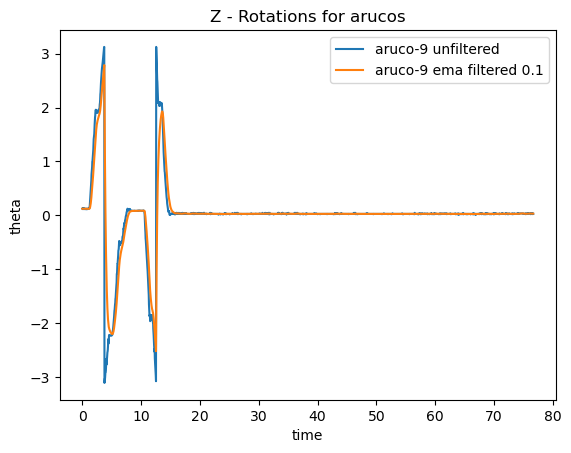

In [64]:
aruco_9_rot_list = Rotation.from_rotvec(aruco_9_rotations)
aruco_8_rot_inv_list = aruco_8_rotations.inv()
R8_0_inv = aruco_8_rot_inv_list[0]
zeroed_rotations = (R8_0_inv * aruco_9_rot_list)
zeroed_rotation_vecs = zeroed_rotations.as_rotvec()
z_rotations = zeroed_rotation_vecs[:,2]
ema_filtered = ewma_vectorized(z_rotations, 0.1)

plt.close("all")

plt.plot(time, z_rotations, label=f"aruco-9 unfiltered")
plt.plot(time, ema_filtered, label=f"aruco-9 ema filtered 0.1")


    
# Add Title
plt.title(f"Z - Rotations for arucos") 

# Add Axes Labels

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()

In [69]:
# alignment calibration
side_view_folder = "/home/joseph/Documents/project/videos/calibration_images/rotation_calibration/side_view_LG/"
alignment_folder = side_view_folder + "alignment/"


In [65]:
rod_12_alignment_images = ["20241112_122114.jpg", "20241112_122124.jpg", "20241112_122131.jpg"]
rod_11_alignment_images = ["20241112_122144.jpg", "20241112_122150.jpg", "20241112_122155.jpg"]
rod_10_alignment_images = ["20241112_122203.jpg", "20241112_122236.jpg", "20241112_122246.jpg"]
rod_9_alignment_images = ["20241112_122302.jpg", "20241112_122314.jpg", "20241112_122320.jpg"]

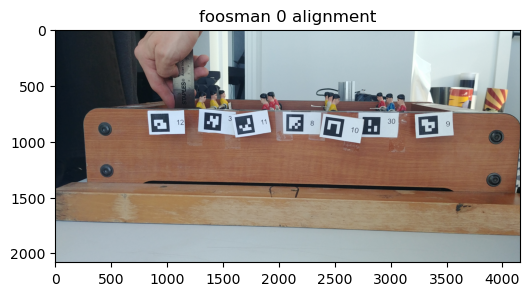

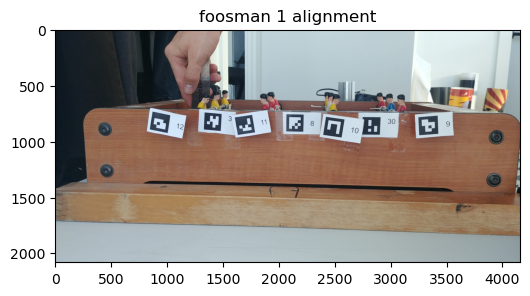

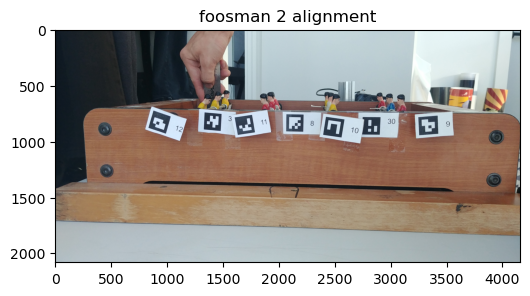

In [70]:
for index, file_name in enumerate(rod_12_alignment_images):
    plt.figure(figsize=(6, 4))
    plt.title(f"foosman {index} alignment")
    plt.imshow(Image.open(os.path.join(alignment_folder, file_name)))

In [78]:
reference_id = 8
rod_id = 12

# define list of 3 rotation vectors, one for each foosman
foosman_rotation_vectors = np.zeros((3,3))
reference_rotation_vectors = np.zeros((3,3))

for index, file_name in enumerate(rod_12_alignment_images):
    img = cv2.imread(os.path.join(alignment_folder, file_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    arucoParameters =  cv2.aruco.DetectorParameters()
    arucoDetector = cv2.aruco.ArucoDetector(arucoDict, arucoParameters)
    
    # lists of ids and the corners beloning to each id
    corners, ids, rejected_img_points = arucoDetector.detectMarkers(gray)
    
    id_list = ids.flatten()
    corner_dict = {id_list[i]: corners[i] for i in range(len(id_list))}

    # get pose of reference marker
    reference_rvec = get_pose_of_id(reference_id, corner_dict, marker_size, matrix_coefficients, distortion_coefficients)
    
    # get pose of rod marker
    rod_rvec = get_pose_of_id(rod_id, corner_dict, marker_size, matrix_coefficients, distortion_coefficients)
    
    foosman_rotation_vectors[index] = rod_rvec.flatten()
    reference_rotation_vectors[index] = reference_rvec.flatten()


In [80]:
reference_rotation_list = Rotation.from_rotvec(reference_rotation_vectors)
reference_rotation_inv_list = reference_rotation_list.inv()

rod_12_rotation_list = Rotation.from_rotvec(foosman_rotation_vectors)
rod_12_zeroed_rotations = (reference_rotation_inv_list * rod_12_rotation_list)

rod_12_zeroed_rotation_vecs = rod_12_zeroed_rotations.as_rotvec()


[[-0.02950198 -0.65173015  0.11521661]
 [-0.47866422 -0.2428298  -0.26561158]
 [-0.44954698 -0.29070573 -0.37880607]]


In [81]:
print(rod_12_zeroed_rotation_vecs * 180 / np.pi)

[[ -1.69033885 -37.34138686   6.60142564]
 [-27.42543951 -13.91312265 -15.21842279]
 [-25.75714477 -16.65621166 -21.70398921]]


In [95]:
aruco_12_rot_vecs = rotations[:,id_index_dict[12],:]
aruco_12_rot_list = Rotation.from_rotvec(aruco_12_rot_vecs)
# aruco_8_rot_inv_list = aruco_8_rotations.inv()
# R8_0_inv = aruco_8_rot_inv_list[0]

zeroed_foosman_rotations = (R8_0_inv * aruco_12_rot_list)
calibrated_foosman_rotations_0 = zeroed_foosman_rotations * rod_12_zeroed_rotations[0]
calibrated_foosman_rotations_1 = zeroed_foosman_rotations * rod_12_zeroed_rotations[1]
calibrated_foosman_rotations_2 = zeroed_foosman_rotations * rod_12_zeroed_rotations[2]

calibrated_rot_vecs = np.array([x.as_rotvec() for x in [calibrated_foosman_rotations_0, calibrated_foosman_rotations_1, calibrated_foosman_rotations_2]])

print(len(calibrated_rot_vecs))
print(calibrated_rot_vecs.shape)

calibrated_foosman_z_angle = calibrated_rot_vecs[:,:,2]
print(calibrated_foosman_z_angle.shape)


3
(3, 2302, 3)
(3, 2302)


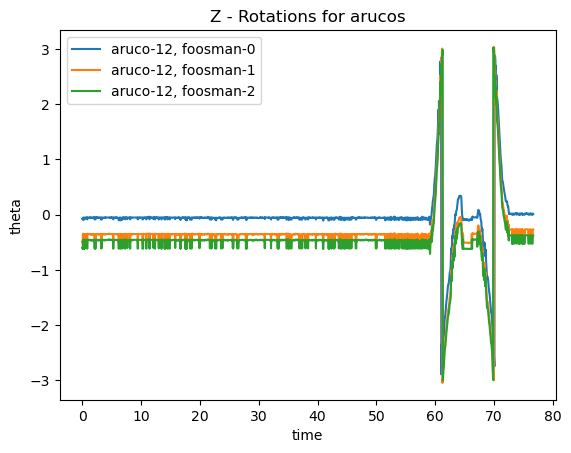

In [96]:
aruco_id = 12

plt.close("all")
for i in range(0,3):
    plt.plot(time, calibrated_foosman_z_angle[i,:], label=f"aruco-{aruco_id}, foosman-{i}")
    
    
# Add Title
plt.title(f"Z - Rotations for arucos") 

# Add Axes Labels

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()
    

In [106]:
aruco_12_rot_vecs = rotations[:,id_index_dict[12],:]
aruco_12_rot_list = Rotation.from_rotvec(aruco_12_rot_vecs)
# aruco_8_rot_inv_list = aruco_8_rotations.inv()
# R8_0_inv = aruco_8_rot_inv_list[0]

calibrated_foosman_rotations_0 = aruco_12_rot_list * rod_12_rotation_list[0].inv()
calibrated_foosman_rotations_1 = aruco_12_rot_list * rod_12_rotation_list[1].inv()
calibrated_foosman_rotations_2 = aruco_12_rot_list * rod_12_rotation_list[2].inv()

calibrated_rot_vecs = np.array([x.as_rotvec() for x in [calibrated_foosman_rotations_0, calibrated_foosman_rotations_1, calibrated_foosman_rotations_2]])

print(len(calibrated_rot_vecs))
print(calibrated_rot_vecs.shape)

calibrated_foosman_z_angle = calibrated_rot_vecs[:,:,2]
print(calibrated_foosman_z_angle.shape)

3
(3, 2302, 3)
(3, 2302)


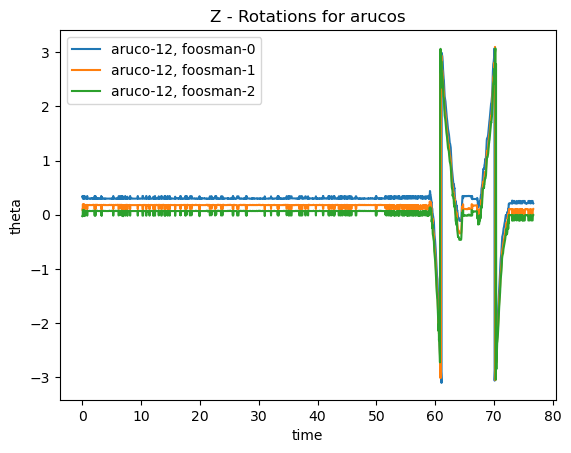

In [107]:
aruco_id = 12

plt.close("all")
for i in range(0,3):
    plt.plot(time, calibrated_foosman_z_angle[i,:], label=f"aruco-{aruco_id}, foosman-{i}")
    
    
# Add Title
plt.title(f"Z - Rotations for arucos") 

# Add Axes Labels

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()
    

In [ ]:
aruco_12_rot_vecs = rotations[:,id_index_dict[12],:]
aruco_12_rot_list = Rotation.from_rotvec(aruco_12_rot_vecs)
# aruco_8_rot_inv_list = aruco_8_rotations.inv()
# R8_0_inv = aruco_8_rot_inv_list[0]

calibrated_foosman_rotations_0 = aruco_12_rot_list * rod_12_rotation_list[0].inv()
calibrated_foosman_rotations_1 = aruco_12_rot_list * rod_12_rotation_list[1].inv()
calibrated_foosman_rotations_2 = aruco_12_rot_list * rod_12_rotation_list[2].inv()

calibrated_rot_vecs = np.array([x.as_rotvec() for x in [calibrated_foosman_rotations_0, calibrated_foosman_rotations_1, calibrated_foosman_rotations_2]])

print(len(calibrated_rot_vecs))
print(calibrated_rot_vecs.shape)

calibrated_foosman_z_angle = calibrated_rot_vecs[:,:,2]
print(calibrated_foosman_z_angle.shape)

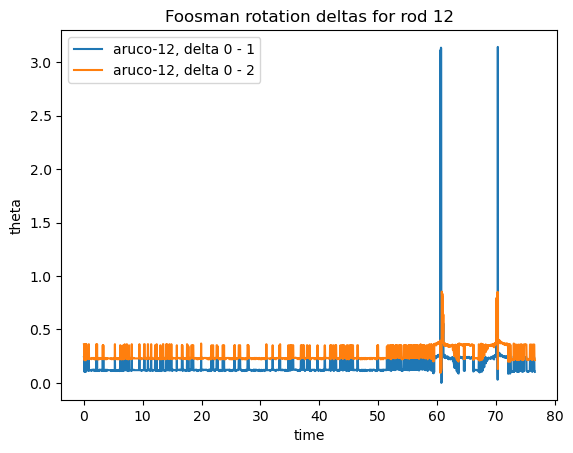

In [112]:
delta_foos0_foos1 = calibrated_foosman_z_angle[0,:] - calibrated_foosman_z_angle[1,:]
delta_foos0_foos2 = calibrated_foosman_z_angle[0,:] - calibrated_foosman_z_angle[2,:]

delta_foos0_foos1 = np.fmod(delta_foos0_foos1 + 2 * np.pi, np.pi)
delta_foos0_foos2 = np.fmod(delta_foos0_foos2 + 2 * np.pi, np.pi)

plt.close("all")

plt.plot(time, delta_foos0_foos1, label=f"aruco-{aruco_id}, delta 0 - 1")
plt.plot(time, delta_foos0_foos2, label=f"aruco-{aruco_id}, delta 0 - 2")
    
# Add Title
plt.title(f"Foosman rotation deltas for rod 12") 

# Add Axes Labels

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
# Display

plt.show()
    


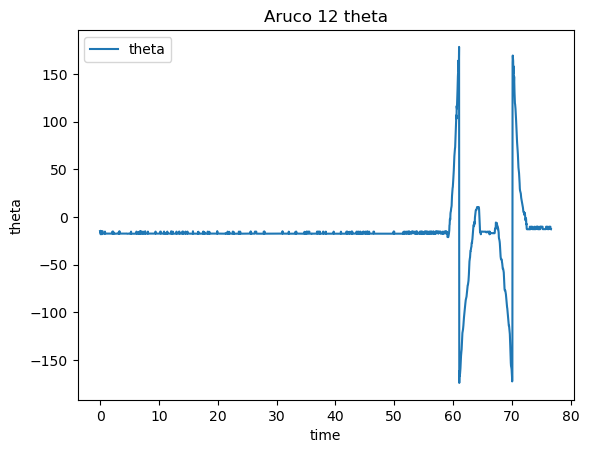

In [101]:
aruco_12_rot_vecs = rotations[:,id_index_dict[12],:]
aruco_12_rot_list = Rotation.from_rotvec(aruco_12_rot_vecs)
# aruco_8_rot_inv_list = aruco_8_rotations.inv()
# R8_0_inv = aruco_8_rot_inv_list[0]

aruco_12_rot_list_zeroed = (R8_0_inv * aruco_12_rot_list)
plt.close("all")
plot_theta(12, aruco_12_rot_list_zeroed.as_rotvec()[:,2], time)

<function matplotlib.pyplot.show(close=None, block=None)>

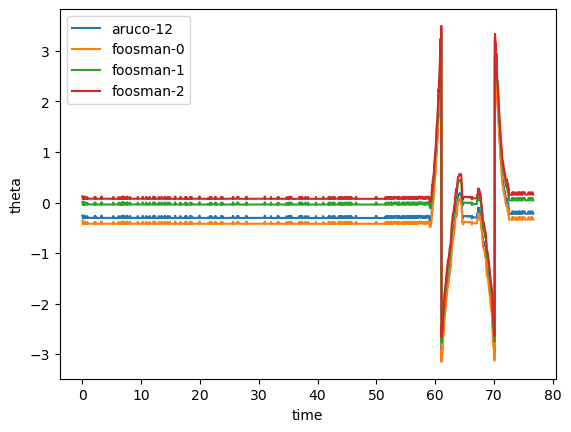

In [120]:
alignment_z_offsets = rod_12_zeroed_rotations.inv().as_rotvec()[:,2]
aruco_12_theta = aruco_12_rot_list_zeroed.as_rotvec()[:,2]

plt.close("all")
plt.plot(time, aruco_12_theta, label=f"aruco-12")
for i in range(0,3):
    plt.plot(time, aruco_12_theta + alignment_z_offsets[i], label=f"foosman-{i}")

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show

In [122]:
def get_foosman_alignments(rod_ids, reference_id, imageFolder, imageList, numFoosmenPerRod=3):
    numRods = len(rod_ids)
    foosman_rotation_vectors = np.zeros((numRods, numFoosmenPerRod,3))
    reference_rotation_vectors = np.zeros((numRods, numFoosmenPerRod,3))

    for rod_idx, rod_id in enumerate(rod_ids):
        alignment_images = imageList[rod_idx]

        for img_idx, file_name in enumerate(alignment_images):
            img = cv2.imread(os.path.join(imageFolder, file_name))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
            arucoParameters =  cv2.aruco.DetectorParameters()
            arucoDetector = cv2.aruco.ArucoDetector(arucoDict, arucoParameters)
            
            # lists of ids and the corners beloning to each id
            corners, ids, rejected_img_points = arucoDetector.detectMarkers(gray)
            
            id_list = ids.flatten()
            corner_dict = {id_list[i]: corners[i] for i in range(len(id_list))}
        
            # get pose of reference marker
            reference_rvec = get_pose_of_id(reference_id, corner_dict, marker_size, matrix_coefficients, distortion_coefficients)
            
            # get pose of rod marker
            rod_rvec = get_pose_of_id(rod_id, corner_dict, marker_size, matrix_coefficients, distortion_coefficients)
            
            foosman_rotation_vectors[rod_idx, img_idx] = rod_rvec.flatten()
            reference_rotation_vectors[rod_idx, img_idx] = reference_rvec.flatten()

    return foosman_rotation_vectors, reference_rotation_vectors

In [124]:

referenceId = 8
rodIds = [9, 10, 11, 12]
imageList = [rod_9_alignment_images, rod_10_alignment_images, rod_11_alignment_images, rod_12_alignment_images]
foosman_rot_vecs, reference_rot_vecs = get_foosman_alignments(rodIds, reference_id, alignment_folder, imageList, numFoosmenPerRod=3)

In [132]:
def get_theta_offsets_for_rod_calibrated_to_foosman_0(aruco_rvecs):
    aruco_rod_rotations = Rotation.from_rotvec(aruco_rvecs)
    aruco_rod_foosman_0_rotation_inv = aruco_rod_rotations[0].inv()
    aruco_rod_zeroed_rotations = aruco_rod_foosman_0_rotation_inv * aruco_rod_rotations
    
    aruco_foosman_theta_offsets = aruco_rod_zeroed_rotations.as_rotvec()[:,2]
    return aruco_foosman_theta_offsets

In [134]:
for idx, rod_id in enumerate(rodIds):
    aruco_rod_rvecs = foosman_rot_vecs[idx]
    foosman_offsets = get_theta_offsets_for_rod_calibrated_to_foosman_0(aruco_rod_rvecs)
    print(f"foosman alignment for rod {rod_id}")
    print(foosman_offsets * 180 / np.pi)
    

foosman alignment for rod 9
[ 0.         -2.87920689 -3.83271611]
foosman alignment for rod 10
[  0.          -6.12766447 -13.74226049]
foosman alignment for rod 11
[  0.           1.58121192 -15.37725851]
foosman alignment for rod 12
[  0.         -12.24342305 -18.88451866]


In [135]:
print(foosman_rot_vecs.shape)

(4, 3, 3)


In [136]:
def get_rod_rotations_to_reference_aruco(foosman_rot_vecs, reference_rot_vecs):
    # only need to pass in first alignment image for each rod
    foosman_0_rot_vecs = foosman_rot_vecs[:,0]
    foosman_0_rotations = Rotation.from_rotvec(foosman_0_rot_vecs)
    reference_0_rot_vecs = reference_rot_vecs[:,0]
    reference_0_rotations = Rotation.from_rotvec(reference_0_rot_vecs)

    rotation_reference_to_foosman = reference_0_rotations.inv() * foosman_0_rotations
    return rotation_reference_to_foosman

In [139]:
reference_to_foosman_0_rotations = get_rod_rotations_to_reference_aruco(foosman_rot_vecs, reference_rot_vecs)
reference_to_foosman_0_rvecs = reference_to_foosman_0_rotations.as_rotvec()

print(reference_to_foosman_0_rvecs*180/np.pi)

[[ -6.21474016 124.8683054   97.92788965]
 [ 51.95923329 108.75195382 -68.35806504]
 [-13.62224733 -21.65458028   9.92406906]
 [ -1.69033885 -37.34138686   6.60142564]]


In [140]:
print(reference_rot_vecs)

[[[-2.96646291 -0.04138955 -0.64889699]
  [-2.96613691 -0.04540799 -0.66367745]
  [-2.96280947 -0.03294792 -0.65984581]]

 [[-2.96766005 -0.03303935 -0.64904408]
  [-2.96896867 -0.04453927 -0.65696156]
  [-2.96372459 -0.03505467 -0.6563158 ]]

 [[-2.96491022 -0.0350753  -0.65366389]
  [-2.96608337 -0.03509561 -0.65103369]
  [-2.96491022 -0.0350753  -0.65366389]]

 [[-2.96481191 -0.03464177 -0.66271293]
  [-2.96058249 -0.03498571 -0.66224426]
  [-2.96143511 -0.0380916  -0.67475393]]]


In [141]:
print(foosman_rot_vecs)

[[[-0.07252452  1.87121261 -2.23684319]
  [-0.12213539  1.88896084 -2.26914977]
  [-0.13780108  1.89367314 -2.28119997]]

 [[-0.44554622 -1.32267639 -2.18747231]
  [ 0.80070874 -1.38636297  2.66521018]
  [ 0.88430257 -1.23118287  2.50601985]]

 [[ 3.03407354 -0.26811869  0.070697  ]
  [ 3.03098865 -0.31011835  0.07106326]
  [ 3.03549776  0.13986901  0.05131606]]

 [[-3.03511988  0.09469753  0.33192739]
  [ 2.69483707  0.26029841  0.28239634]
  [ 2.67807617  0.42129598  0.23219538]]]


In [148]:
for idx, rod_id in enumerate(rodIds):
    foosman_rotations = Rotation.from_rotvec(foosman_rot_vecs[idx])
    reference_rotations = Rotation.from_rotvec(reference_rot_vecs[idx])
    
    calibration_rotations = reference_to_foosman_0_rotations[idx]
    calibrated_foosman_rotations = calibration_rotations.inv() * reference_rotations.inv() * foosman_rotations

    print(f"calibrated z-rotations for rod {rod_id}")
    calibrated_foosman_rot_vec = calibrated_foosman_rotations.as_rotvec()
    print(calibrated_foosman_rot_vec[:,2] * 180 / np.pi)

calibrated z-rotations for rod 9
[-2.78298535e-15 -3.39831672e+00 -4.20137508e+00]
calibrated z-rotations for rod 10
[-9.54166404e-15 -6.32617206e+00 -1.38558152e+01]
calibrated z-rotations for rod 11
[-9.93923338e-17  1.59144443e+00 -1.53772585e+01]
calibrated z-rotations for rod 12
[  0.         -12.17795492 -18.85663186]
